<a href="https://colab.research.google.com/github/LeraDoroshenko/ksvd/blob/main/%D0%9B%D0%A07_%D0%94%D0%BE%D1%80%D0%BE%D1%88%D0%B5%D0%BD%D0%BA%D0%BE%D0%92__4_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_noisy = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.3),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform_noisy, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform_noisy, download=True)
clean_test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
clean_test_loader = DataLoader(clean_test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.40MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.07MB/s]


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Tanh(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, _ in train_loader:
        data = data.to(device)
        output = model(data)
        loss = criterion(output, data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 0.6238
Epoch 2/10, Loss: 0.5430
Epoch 3/10, Loss: 0.5258
Epoch 4/10, Loss: 0.5177
Epoch 5/10, Loss: 0.5126
Epoch 6/10, Loss: 0.5094
Epoch 7/10, Loss: 0.5068
Epoch 8/10, Loss: 0.5046
Epoch 9/10, Loss: 0.5032
Epoch 10/10, Loss: 0.5021


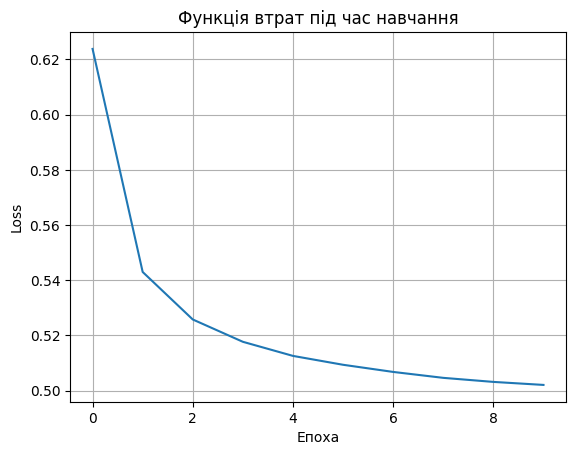

In [6]:
plt.plot(losses)
plt.title("Функція втрат під час навчання")
plt.xlabel("Епоха")
plt.ylabel("Loss")
plt.grid()
plt.show()

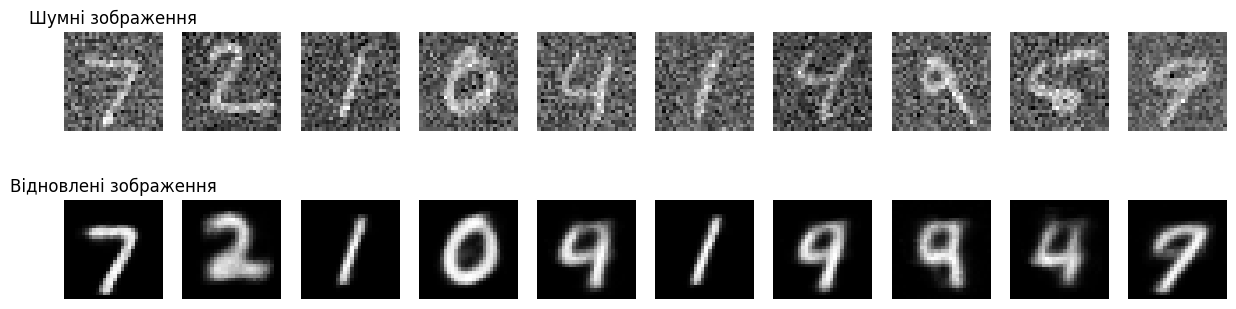

In [7]:
model.eval()
with torch.no_grad():
    dataiter = iter(test_loader)
    noisy_imgs, _ = next(dataiter)
    noisy_imgs = noisy_imgs.to(device)
    outputs = model(noisy_imgs)

    # Вивід
    noisy_imgs = noisy_imgs.cpu()
    outputs = outputs.cpu()

    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 4))
    for i in range(10):
        axes[0, i].imshow(noisy_imgs[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(outputs[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_title("Шумні зображення")
    axes[1, 0].set_title("Відновлені зображення")
    plt.show()